# Algoritmo de Classificação
### Fraude em transações de pagamento
<hr>

## Importando Pacotes

In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Carregando Dados

In [184]:
data = pd.read_csv('./data/02_fraud_classification.csv')
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## Análise Exploratória

In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [186]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [187]:
print(f'Transações:\n{data.type.value_counts()}')

Transações:
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [188]:
type = data['type'].value_counts()
transactions = type.index
values = type.values

figure = px.pie(data, values=values, names=transactions, hole = 0.5, title="Distribuição das Transações")
figure.show()

In [189]:
correlacao = data.corr()
print(f'Correlações do Target:\n{correlacao.isFraud.sort_values(ascending=False)}')

Correlações do Target:
isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


## Pré-Processamento dos Dados

In [190]:
data['type'] = data['type'].map({'CASH_OUT':1, 'PAYMENT':2, 'CASH_IN':3, 'TRANSFER': 4, 'DEBIT':5})
data['isFraud'] = data['isFraud'].map({0:'No Fraud',1:'Fraud'})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,No Fraud,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,No Fraud,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Fraud,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Fraud,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,No Fraud,0


In [191]:
data.isFraud.value_counts()

No Fraud    6354407
Fraud          8213
Name: isFraud, dtype: int64

## Separando as Bases

In [192]:
x = data[['type','amount','oldbalanceOrg','newbalanceOrig']]
y = data[['isFraud']]

In [193]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10,  random_state=42)

In [194]:
print(f'Quantidade de dados para treino: {x_train.shape[0]}\nQuantidade de dados para teste: {x_test.shape[0]}\nTotal: {x_train.shape[0] + y_test.shape[0]}')
print(f'\nPorcentagem de dados para teste: {len(x_test) / len(x_train) *100:.2f}%')

Quantidade de dados para treino: 5726358
Quantidade de dados para teste: 636262
Total: 6362620

Porcentagem de dados para teste: 11.11%


## Modelo

In [195]:
model = DecisionTreeClassifier()

## Treino

In [196]:
model.fit(x_train, y_train)

DecisionTreeClassifier()

## Teste

In [197]:
predicao = model.predict(x_test)

## Avaliação

In [198]:
Report = classification_report(y_test, predicao)
print(f'{Report}\nAcurácia: {accuracy_score(y_test, predicao):.2f}')

              precision    recall  f1-score   support

       Fraud       0.90      0.88      0.89       817
    No Fraud       1.00      1.00      1.00    635445

    accuracy                           1.00    636262
   macro avg       0.95      0.94      0.95    636262
weighted avg       1.00      1.00      1.00    636262

Acurácia: 1.00


## Matriz de Confusão

Matriz de Confusão:
[[   723     94]
 [    79 635366]]


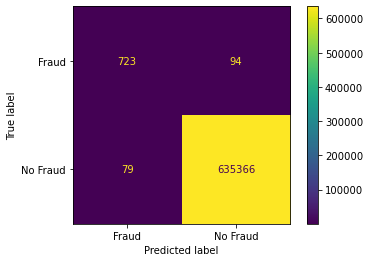

In [199]:
print(f'Matriz de Confusão:\n{confusion_matrix(y_test, predicao)}')

plot_confusion_matrix(model, x_test, y_test)  
plt.show()

# Indica que 723 são fraudes - Verdade
# Indica que 94 são fraudes - mentira
# Indica que 79 não são fraudes - mentira
# Indica que 635... não são fraudes - verdade
# Dica: Os dados existentes nos lados Superior Direito e Inferior Esquerdo são sempre falsos.

## Importância das Features

In [208]:
model.feature_importances_
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
oldbalanceOrg,0.576209
amount,0.313850
newbalanceOrig,0.103441
type,0.006500


## Salvando Dados

In [200]:
df, df['isFraudPredita'] = x_test, predicao
print(f'Fraudes: {df.isFraudPredita.value_counts()[0]}\nNão é Fraude: {df.isFraudPredita.value_counts()[1]}')

Fraudes: 635460
Não é Fraude: 802


In [201]:
df.to_csv('./output/02_fraud_classification_Model.csv')

## Salvando o Modelo

In [209]:
joblib.dump(model, './model/02_fraud_classification_Model.pkl')

['./model/02_fraud_classification_Model.pkl']